<a href="https://colab.research.google.com/github/ValenzuelaDiego/proyectoInteligenciaArtificial/blob/main/MountainCar_DV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab


In [72]:
if COLAB:
  !sudo apt-get install -y xvfb ffmpeg x11-utils
  !pip install -q 'gym==0.17.0'
  !pip install -q 'imageio==2.4.0'
  !pip install -q PILLOW
  !pip install -q 'pyglet==1.5.0'
  !pip install -q pyvirtualdisplay
  !pip install -q tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


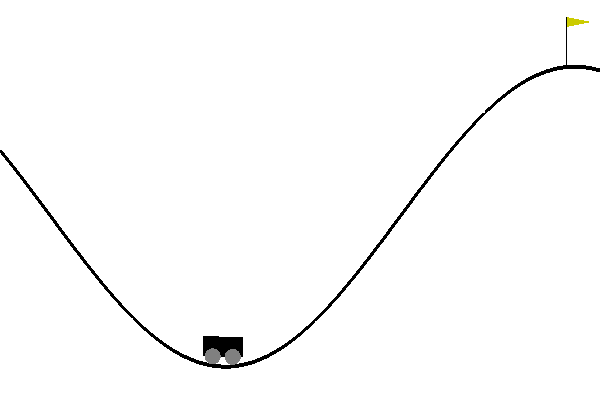

In [73]:
import tf_agents
from tf_agents.environments import suite_gym
import PIL.Image
import pyvirtualdisplay

display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

env_name = 'MountainCar-v0'
env = suite_gym.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

Funciones necesarias para poder observar el MontainCar:

In [74]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

Empieza la parte de Q learning

In [75]:
import gym
import numpy as np

# This function converts the floating point state values into 
# discrete values. This is often called binning.  We divide 
# the range that the state values might occupy and assign 
# each region to a bucket.
def calc_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/buckets
    return tuple(discrete_state.astype(np.int))  

# Run one game.  The q_table to use is provided.  We also 
# provide a flag to indicate if the game should be 
# rendered/animated.  Finally, we also provide
# a flag to indicate if the q_table should be updated.
def run_game(q_table, render, should_update):
    done = False
    discrete_state = calc_discrete_state(env.reset())
    success = False
    
    while not done:
        # Exploit or explore
        if np.random.random() > epsilon:
            # Exploit - use q-table to take current best action 
            # (and probably refine)
            action = np.argmax(q_table[discrete_state])
        else:
            # Explore - t
            action = np.random.randint(0, env.action_space.n)
            
        # Run simulation step
        new_state, reward, done, _ = env.step(action)
        
        # Convert continuous state to discrete
        new_state_disc = calc_discrete_state(new_state)

        # Have we reached the goal position (have we won?)?
        if new_state[0] >= env.unwrapped.goal_position:
            success = True
          
        # Update q-table
        if should_update:
            max_future_q = np.max(q_table[new_state_disc])
            current_q = q_table[discrete_state + (action,)]
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * \
              (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action,)] = new_q

        discrete_state = new_state_disc
        
        if render:
            env.render()
            
    return success



Parametros Importantes a Configurar aqui:
*   Learning rate = Coeficiente de Aprendizaje que se utilizara en la funcion de estimacion de estados.
*   Discount = Descuento realizado.
*   Episodes = Numero de episodios que se realizaran en total.
*   Show_Every= Cada cuanto se realizara un corte para mostrar los resultados de exitos/fracasos. 



In [76]:
LEARNING_RATE = 0.1
DISCOUNT = 0.95
EPISODES = 30000
SHOW_EVERY = 1000

DISCRETE_GRID_SIZE = [10, 10]
START_EPSILON_DECAYING = 0.5
END_EPSILON_DECAYING = EPISODES//10

Parametros a configurar aquí:


*   Epsilon = porcentaje que determina si se realiza EXPLORACION O EXPLOTACION. Un valor de Epsilon cercano a 0 determina explotación, un valor de Epsilon cercano a 1 determina exploración.



In [77]:
if COLAB:
  env = wrap_env(gym.make("MountainCar-v0"))
else:
  env = gym.make("MountainCar-v0")

epsilon = 1
epsilon_change = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
buckets = (env.observation_space.high - env.observation_space.low) \
    /DISCRETE_GRID_SIZE
q_table = np.random.uniform(low=-3, high=0, size=(DISCRETE_GRID_SIZE \
    + [env.action_space.n]))
success = False

A continuación se ejecutan las funciones y se obtienen los resultados correspondientes:

In [78]:
episode = 0
success_count = 0
y=[]

# Loop through the required number of episodes
while episode<EPISODES:
    episode+=1
    done = False

    # Run the game.  If we are local, display render animation at SHOW_EVERY
    # intervals. 
    if episode % SHOW_EVERY == 0:
        print(f"Current episode: {episode}, success: {success_count}, porcentaje: {float(success_count*100)/SHOW_EVERY}, %")
        success = run_game(q_table, True, False)
        y.append(success_count)
        success_count = 0
    else:
        success = run_game(q_table, False, True)
        
    # Count successes
    if success:
        success_count += 1

    # Move epsilon towards its ending value, if it still needs to move
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon = max(0, epsilon - epsilon_change)

print(success)

Current episode: 1000, success: 0, porcentaje: 0.0, %
Current episode: 2000, success: 1, porcentaje: 0.1, %
Current episode: 3000, success: 208, porcentaje: 20.8, %
Current episode: 4000, success: 678, porcentaje: 67.8, %
Current episode: 5000, success: 516, porcentaje: 51.6, %
Current episode: 6000, success: 529, porcentaje: 52.9, %
Current episode: 7000, success: 208, porcentaje: 20.8, %
Current episode: 8000, success: 614, porcentaje: 61.4, %
Current episode: 9000, success: 677, porcentaje: 67.7, %
Current episode: 10000, success: 669, porcentaje: 66.9, %
Current episode: 11000, success: 615, porcentaje: 61.5, %
Current episode: 12000, success: 731, porcentaje: 73.1, %
Current episode: 13000, success: 977, porcentaje: 97.7, %
Current episode: 14000, success: 997, porcentaje: 99.7, %
Current episode: 15000, success: 997, porcentaje: 99.7, %
Current episode: 16000, success: 995, porcentaje: 99.5, %
Current episode: 17000, success: 996, porcentaje: 99.6, %
Current episode: 18000, succe

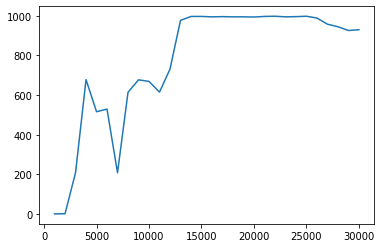

In [79]:
from matplotlib import pyplot as plt

x=np.arange(1000,31000,1000)
if len(x)==len(y):
  plt.plot(x,y)
else:
  print('X e Y no tienen la misma longitud')


In [80]:
run_game(q_table, True, False)
show_video()

In [81]:
import pandas as pd

df = pd.DataFrame(q_table.argmax(axis=2))

df.columns = [f'v-{x}' for x in range(DISCRETE_GRID_SIZE[0])]
df.index = [f'p-{x}' for x in range(DISCRETE_GRID_SIZE[1])]
df

,v-0,v-1,v-2,v-3,v-4,v-5,v-6,v-7,v-8,v-9
p-0,2,2,0,2,2,2,2,2,1,2
p-1,0,2,1,1,0,1,2,2,2,1
p-2,0,0,0,2,2,2,1,2,2,0
p-3,0,0,0,0,2,2,2,2,2,2
p-4,0,0,0,0,0,2,2,2,2,2
p-5,0,0,0,0,0,1,1,2,1,2
p-6,1,0,0,0,1,0,0,1,1,0
p-7,1,2,2,0,0,1,1,2,2,1
p-8,1,0,0,0,0,0,0,2,1,1
p-9,2,0,1,1,0,0,0,2,2,1


In [82]:
df.mean(axis=0)

v-0    0.7
v-1    0.6
v-2    0.4
v-3    0.6
v-4    0.7
v-5    1.1
v-6    1.1
v-7    1.9
v-8    1.6
v-9    1.2
dtype: float64

In [83]:
df.mean(axis=1)

p-0    1.7
p-1    1.2
p-2    1.1
p-3    1.2
p-4    1.0
p-5    0.7
p-6    0.4
p-7    1.2
p-8    0.5
p-9    0.9
dtype: float64